# Importing Necessary Libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import mode
#import catboost as cgb

# Importing Dataset:
Here we have 5 to 6 tables which will be used for feature Engineering:
We have customer data, item data, campaign data and table which maps coupons to items.

Now first focus is on Feature Engineering.
1. Campaign data has information about campaigns and date ranges
2. coupon item has maping coupons with respective items
3. Customer dempgraphic table has customer's personal information
4. Customer transaction table has information of customers id, what item id is purchased and what coupon and discounts are used. (Here lots of enginnering is performed to create data for total discounts, discount percentage, total purchase, min amount spend by customer and many more )
5. item table has information about item brand and in what category it lies.


Step By Step we will perfom feature Enginneing. 
    

In [2]:
train=pd.read_csv('train.csv')
test =pd.read_csv('test_QyjYwdj.csv')
coupon_item=pd.read_csv('coupon_item_mapping.csv')
campaign=pd.read_csv('campaign_data.csv')
customer_demo=pd.read_csv('customer_demographics.csv')
customer_transact=pd.read_csv('customer_transaction_data.csv')
item=pd.read_csv('item_data.csv')
sample=pd.read_csv('sample_submission_Byiv0dS.csv')

In [3]:
# Shape of the data set:
train.shape, test.shape,coupon_item.shape,campaign.shape,customer_demo.shape,customer_transact.shape,item.shape,sample.shape


((78369, 5),
 (50226, 4),
 (92663, 2),
 (28, 4),
 (760, 7),
 (1324566, 7),
 (74066, 4),
 (50226, 2))

In [4]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [5]:
# output value count
train['redemption_status'].value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [6]:
train['redemption_status'].value_counts('percentage')

0    0.990698
1    0.009302
Name: redemption_status, dtype: float64

# Cleaning, Preprocessing and Feature Engineering

# we will go step by step through all the datasets
## Table A: Customer Demographic Details 

In [7]:
customer_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [8]:
customer_demo.isnull().sum()
# We see some NA values in marital status, and number of childern
# those with NAN childern will be made as zero children.
# those have children>0 marital status will be change to married else single

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [9]:
customer_demo['no_of_children'].fillna(0,inplace=True)
customer_demo['no_of_children'].value_counts()

0     538
1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [10]:
# 3+ is converted to 4
customer_demo['no_of_children']=customer_demo['no_of_children'].apply(lambda x: 4 if x=='3+' else x )
customer_demo['no_of_children']=customer_demo['no_of_children'].astype(np.int64)

In [11]:
customer_demo['marital_status']=customer_demo.apply(lambda x: 'Married' if x.no_of_children > 0 else 'Single',axis = 1)

In [12]:
customer_demo.isnull().sum()

customer_id       0
age_range         0
marital_status    0
rented            0
family_size       0
no_of_children    0
income_bracket    0
dtype: int64

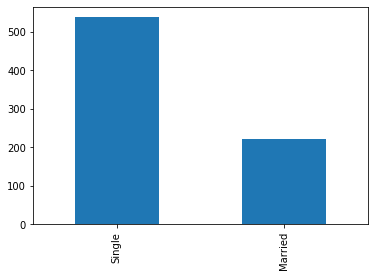

In [13]:
# Singles are more than married.
customer_demo['marital_status'].value_counts().plot(kind='bar')

In [14]:
customer_demo['family_size'].value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [15]:
customer_demo['family_size']=customer_demo['family_size'].apply(lambda x: 6 if x =='5+' else x)
customer_demo['family_size']= customer_demo['family_size'].astype(np.int64)

In [16]:
# Age range and marital status are categorical features 
customer_demo['marital_status']=encoder.fit_transform(customer_demo['marital_status'])
customer_demo['age_range']=encoder.fit_transform(customer_demo['age_range'])

In [17]:
customer_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,5,1,0,2,0,4
1,6,3,1,0,2,0,5
2,7,1,0,0,3,1,3
3,8,1,0,0,4,2,6
4,10,3,1,0,1,0,5


## Table B: Campaign Data 

In [18]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [19]:
campaign.isnull().sum()

campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64

In [20]:
# Encoding campaign type
campaign['campaign_type']=encoder.fit_transform(campaign['campaign_type'])

#converting dates to date_time formate
campaign["start_date"] = pd.to_datetime(campaign["start_date"], dayfirst=True)
campaign["end_date"] = pd.to_datetime(campaign["end_date"], dayfirst=True)

# Creatinn a new column for campaign duration
campaign['campaign_duration']=campaign['end_date']-campaign['start_date']

cam_start = min(campaign.start_date)
cam_end = max(campaign.end_date)

In [21]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,1,2013-10-21,2013-12-20,60 days
1,25,1,2013-10-21,2013-11-22,32 days
2,20,1,2013-09-07,2013-11-16,70 days
3,23,1,2013-10-08,2013-11-15,38 days
4,21,1,2013-09-16,2013-10-18,32 days


In [22]:
campaign['campaign_duration']=campaign['campaign_duration'].apply(lambda x:x.days)
campaign.head()

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,1,2013-10-21,2013-12-20,60
1,25,1,2013-10-21,2013-11-22,32
2,20,1,2013-09-07,2013-11-16,70
3,23,1,2013-10-08,2013-11-15,38
4,21,1,2013-09-16,2013-10-18,32


## Table C: Item Type

In [23]:
item.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [24]:
item.isnull().sum()

item_id       0
brand         0
brand_type    0
category      0
dtype: int64

In [25]:
# brand type and category are categorical features;
item.brand_type=encoder.fit_transform(item['brand_type'])
item.category=encoder.fit_transform(item['category'])

## Table D: Customer Transactin data

In [26]:
customer_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [27]:
customer_transact.isnull().sum()

date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64

In [28]:
# convert date to date time and sort values according to date
customer_transact['date']=pd.to_datetime(customer_transact['date'],dayfirst=True)
customer_transact = customer_transact.sort_values('date').reset_index(drop=True)
customer_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62
2,2012-01-02,464,20717,2,28.50,-27.78,0.00
3,2012-01-02,464,21008,1,35.26,-17.81,0.00
4,2012-01-02,464,22243,2,118.97,-22.80,0.00


In [29]:
# Adding different columns to show different days months and weekday 
customer_transact['day']=customer_transact['date'].apply(lambda x: x.day)
customer_transact['dow']=customer_transact['date'].apply(lambda x: x.weekday())
customer_transact['month']=customer_transact['date'].apply(lambda x: x.month)

In [30]:
# Performing Operatons on data for each unit purchased

# unit price of the item
customer_transact.selling_price=customer_transact.selling_price/customer_transact.quantity
# unit discount on each item
customer_transact.other_discount=customer_transact.other_discount/customer_transact.quantity
# Actual selling price per unit:
customer_transact.selling_price=customer_transact.selling_price + customer_transact.other_discount
# defining whether customer availed coupon discount or not?
customer_transact['coupon_used']=customer_transact.coupon_discount.apply(lambda x: 1 if x!= 0 else 0)

In [31]:
customer_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month,coupon_used
0,2012-01-02,1501,26830,1,24.570,-10.69,0.00,2,0,1,0
1,2012-01-02,464,20697,1,70.890,-21.37,-35.62,2,0,1,1
2,2012-01-02,464,20717,2,0.360,-13.89,0.00,2,0,1,0
3,2012-01-02,464,21008,1,17.450,-17.81,0.00,2,0,1,0
4,2012-01-02,464,22243,2,48.085,-11.40,0.00,2,0,1,0


## Table E: Coupon item data

In [32]:
coupon_item.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [33]:
coupon_item.isnull().sum()

coupon_id    0
item_id      0
dtype: int64

## Data Cleaning is done now we will merge the data of different tables 
## We will create train data as following:


1. Merge coupon item table with item table == coupons
2. Aggregate Transaction in cutomer transaction data by item id for different coupon counts and sums ==trans1 and trans2
3. Merge coupons item with the transactions table == item_coupon_trans
4. Aggregate coupen item transaction table on coupon id == Coupons
5. Aggregate Transaction on custom id == Trans1 and Trans2 calcualte same as of point 2 again
6. Merger all
**Now we have following tables:**
 1. customer demographic
 2. campaign
 3. coupons
 4. Transactions
 
**Merge this with test and train dataset**

**1.Merge coupen item table with item table** 

In [34]:
# 1.Merge coupen item table with item table
coupons_item = pd.merge(coupon_item, item, on="item_id", how="left")

In [35]:
coupons_item.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,1,6
1,107,75,56,1,6
2,494,76,209,0,6
3,522,77,278,0,6
4,518,77,278,0,6


**2. Aggregate Transaction in cutomer transaction data by item id for different coupon counts and sums** 

In [36]:
customer_transact.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month,coupon_used
0,2012-01-02,1501,26830,1,24.570,-10.69,0.00,2,0,1,0
1,2012-01-02,464,20697,1,70.890,-21.37,-35.62,2,0,1,1
2,2012-01-02,464,20717,2,0.360,-13.89,0.00,2,0,1,0
3,2012-01-02,464,21008,1,17.450,-17.81,0.00,2,0,1,0
4,2012-01-02,464,22243,2,48.085,-11.40,0.00,2,0,1,0


In [37]:
# A pivot table is a table of statistics that summarizes the data of a more extensive table
# (such as from a database, spreadsheet, or business intelligence program). 
# This summary might include sums, averages, or other statistics, which the pivot table groups together in a meaningful way.

# Aggregate transactions by item_id for first time
transactions1 = pd.pivot_table(customer_transact, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used'],
               aggfunc={'customer_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum
                        } )

# len(set(x)) # a set contains unique values so it will take uniques values and len gives length that is number of customers
# bought that item
transactions1.rename(columns={'customer_id': 'unique_customers'}, inplace=True)
# mean is the average value
# sum is the total value, in case of coupons we used it to see how many coupons are used for an item


In [38]:
transactions1.head()

,coupon_discount,coupon_used,unique_customers,other_discount,quantity,selling_price
item_id,,,,,,
1,0.0,0,2,0.0,1.0,124.31
2,0.0,0,1,0.0,1.0,35.26
3,0.0,0,1,0.0,1.0,56.64
4,0.0,0,1,0.0,1.0,54.85
5,0.0,0,1,0.0,1.0,81.57


In [39]:
transactions1.reset_index(inplace=True)

In [40]:
# Aggregate transactions by item_id for second time
transactions2 = pd.pivot_table(customer_transact, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'customer_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,
                        } )
transactions2.reset_index(inplace=True)
transactions2.rename(columns={'customer_id': 'cust_counts', 'quantity':'qu_sum',
                             'selling_price':'price_sum', 'other_discount':'od_sum',
                             'coupon_discount':'cd_sum'}, inplace=True)

In [41]:
transactions2.head()

,item_id,cd_sum,cust_counts,od_sum,qu_sum,price_sum
0,1,0.0,2,0.0,2,248.62
1,2,0.0,1,0.0,1,35.26
2,3,0.0,1,0.0,1,56.64
3,4,0.0,1,0.0,1,54.85
4,5,0.0,1,0.0,1,81.57


In [42]:
# Merge transactions1 and transactions2
transactions1 = pd.merge(transactions1,transactions2,on='item_id',how='left')

In [43]:
transactions1.head()

,item_id,coupon_discount,coupon_used,unique_customers,other_discount,quantity,selling_price,cd_sum,cust_counts,od_sum,qu_sum,price_sum
0,1,0.0,0,2,0.0,1.0,124.31,0.0,2,0.0,2,248.62
1,2,0.0,0,1,0.0,1.0,35.26,0.0,1,0.0,1,35.26
2,3,0.0,0,1,0.0,1.0,56.64,0.0,1,0.0,1,56.64
3,4,0.0,0,1,0.0,1.0,54.85,0.0,1,0.0,1,54.85
4,5,0.0,0,1,0.0,1.0,81.57,0.0,1,0.0,1,81.57


In [44]:
# Adding two new columns
transactions1['total_discount_mean'] = transactions1['coupon_discount'] + transactions1['other_discount']
transactions1['total_discount_sum'] = transactions1['od_sum'] + transactions1['cd_sum']
transactions1.head()

,item_id,coupon_discount,coupon_used,unique_customers,other_discount,quantity,selling_price,cd_sum,cust_counts,od_sum,qu_sum,price_sum,total_discount_mean,total_discount_sum
0,1,0.0,0,2,0.0,1.0,124.31,0.0,2,0.0,2,248.62,0.0,0.0
1,2,0.0,0,1,0.0,1.0,35.26,0.0,1,0.0,1,35.26,0.0,0.0
2,3,0.0,0,1,0.0,1.0,56.64,0.0,1,0.0,1,56.64,0.0,0.0
3,4,0.0,0,1,0.0,1.0,54.85,0.0,1,0.0,1,54.85,0.0,0.0
4,5,0.0,0,1,0.0,1.0,81.57,0.0,1,0.0,1,81.57,0.0,0.0


**3. Merge coupons item with the transactions table**

In [45]:
item_coupon_trans = pd.merge(coupons_item, transactions1, on='item_id', how='left')

In [46]:
item_coupon_trans.head()

,coupon_id,item_id,brand,brand_type,category,coupon_discount,coupon_used,unique_customers,other_discount,quantity,selling_price,cd_sum,cust_counts,od_sum,qu_sum,price_sum,total_discount_mean,total_discount_sum
0,105,37,56,1,6,0.0,0.0,2.0,-8.108333,2.285714,41.030714,0.0,7.0,-56.758333,16.0,287.215,-8.108333,-56.758333
1,107,75,56,1,6,0.0,0.0,4.0,-2.633712,1.363636,33.561061,0.0,33.0,-86.912500,45.0,1107.515,-2.633712,-86.912500
2,494,76,209,0,6,0.0,0.0,1.0,-17.450000,1.000000,71.600000,0.0,1.0,-17.450000,1.0,71.600,-17.450000,-17.450000
3,522,77,278,0,6,0.0,0.0,2.0,-16.920000,1.000000,53.430000,0.0,2.0,-33.840000,2.0,106.860,-16.920000,-33.840000
4,518,77,278,0,6,0.0,0.0,2.0,-16.920000,1.000000,53.430000,0.0,2.0,-33.840000,2.0,106.860,-16.920000,-33.840000


**4. Aggregate coupen item transaction table on coupon id**

In [47]:
coupons = pd.pivot_table(item_coupon_trans, index ="coupon_id",
                         values=[ 'item_id', 'brand', 'brand_type', 'category',
       'coupon_discount', 'coupon_used', 'unique_customers', 'other_discount',
       'quantity', 'selling_price', 'cd_sum', 'cust_counts', 'od_sum', 'qu_sum',
       'price_sum', 'total_discount_mean', 'total_discount_sum'],
              aggfunc={'item_id':lambda x: len(set(x)),  #for a coupon id how many unique items are purchased
                       'brand':lambda x: mode(x)[0][0], # It gives the most common value among all
                       'brand_type':lambda x: mode(x)[0][0],
                       'category':lambda x: mode(x)[0][0],
                       'coupon_discount':np.mean,
                       'unique_customers':np.mean,
                       'other_discount':np.mean,
                       'quantity':np.mean,
                       'selling_price':np.mean,
                      'coupon_used': np.sum,
                       'cd_sum': np.sum,
                       'cust_counts': np.sum,
                       'od_sum': np.sum,
                       'qu_sum': np.sum,
                       'price_sum': np.sum,
                       'total_discount_mean': np.mean,
                       'total_discount_sum': np.sum
                      })
coupons.reset_index(inplace=True)
coupons.rename(columns={'item_id':'item_counts'}, inplace=True)

In [48]:
coupons.head()

,coupon_id,brand,brand_type,category,cd_sum,coupon_discount,coupon_used,cust_counts,item_counts,od_sum,other_discount,price_sum,qu_sum,quantity,selling_price,total_discount_mean,total_discount_sum,unique_customers
0,1,1475,0,9,-1526.31,-1.321524,35.0,826.0,39,-18780.020833,-16.620713,52236.826667,1034.0,1.221644,67.941819,-17.942237,-20306.330833,14.794872
1,2,2084,0,6,0.00,0.000000,0.0,81.0,2,-1163.521667,-21.343885,6613.476667,103.0,1.137500,79.846729,-21.343885,-1163.521667,15.000000
2,3,278,0,6,-578.81,-2.747358,15.0,212.0,17,-4055.343333,-14.728021,19645.803333,248.0,1.121525,102.199851,-17.475379,-4634.153333,8.588235
3,4,544,0,6,-881.59,-1.485152,44.0,676.0,24,-25895.740000,-36.718597,91082.543333,702.0,1.020872,138.271175,-38.203749,-26777.330000,22.333333
4,5,5357,0,11,0.00,0.000000,0.0,44.0,7,-1228.880000,-27.265786,14178.810000,44.0,1.000000,349.438429,-27.265786,-1228.880000,6.000000


**5. Aggregate Transaction on custom id == Trans1 and Trans2 calcualte same as of point 2 again**

In [49]:
# Aggregate transactions by customer_id
Trans1 = pd.pivot_table(customer_transact, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used','day','dow','month'],
               aggfunc={'item_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum,
                        'day':lambda x: mode(x)[0][0],
                        'dow':lambda x: mode(x)[0][0],
                        'month':lambda x: mode(x)[0][0]}
              )
Trans1.reset_index(inplace=True)
Trans1.rename(columns={'item_id': 'unique_items'}, inplace=True)
Trans1.head()

,customer_id,coupon_discount,coupon_used,day,dow,unique_items,month,other_discount,quantity,selling_price
0,1,-2.019876,78,3,3,463,5,-12.837537,1.170802,71.795406
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,80.941393
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,56.932745
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,120.489458
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,92.961449


In [50]:
# Aggregate transactions by customer_id
Trans2 = pd.pivot_table(customer_transact, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'item_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum}
              )
Trans2.reset_index(inplace=True)
Trans2.rename(columns={'item_id': 'item_count','quantity':'qa_sum','selling_price':'pprice_sum',
                             'other_discount':'odd_sum','coupon_discount':'cdd_sum'  }, inplace=True)
Trans2.head()

,customer_id,cdd_sum,item_count,odd_sum,qa_sum,pprice_sum
0,1,-2116.83,1048,-13453.738833,1227,75241.585333
1,2,-249.34,419,-5628.089833,474,33914.443500
2,3,-2179.54,705,-9922.771654,8163,40137.585039
3,4,-89.05,220,-1954.404333,280,26507.680667
4,5,-90.83,792,-8918.471477,93353,73625.467667


In [51]:
# merge above 2
Transactions = pd.merge(Trans1, Trans2, on='customer_id', how='left')

In [52]:
Transactions.head()

,customer_id,coupon_discount,coupon_used,day,dow,unique_items,month,other_discount,quantity,selling_price,cdd_sum,item_count,odd_sum,qa_sum,pprice_sum
0,1,-2.019876,78,3,3,463,5,-12.837537,1.170802,71.795406,-2116.83,1048,-13453.738833,1227,75241.585333
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,80.941393,-249.34,419,-5628.089833,474,33914.443500
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,56.932745,-2179.54,705,-9922.771654,8163,40137.585039
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,120.489458,-89.05,220,-1954.404333,280,26507.680667
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,92.961449,-90.83,792,-8918.471477,93353,73625.467667


**Now we have following tables:**
1. customer demographic == customer id
2. campaign == campaignid
3. coupons == coupon_id
4. Transactions == customer_id

In [53]:
# train and test has following ids== campaingn id, coupon id and customer id
def merge_all(df): 
    df=  pd.merge(df, coupons, on="coupon_id", how="left")
    df = pd.merge(df, campaign, on="campaign_id", how="left")
    df = pd.merge(df, customer_demo, on="customer_id", how="left")
    df = pd.merge(df, Transactions, on='customer_id', how='left')
    return df

In [54]:
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

In [55]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [56]:
train=merge_all(train)

In [57]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,brand,brand_type,category,cd_sum,coupon_discount_x,...,unique_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,item_count,odd_sum,qa_sum,pprice_sum
0,1,13,27,1053,0,1105,0,6,-5349.93,-1.241694,...,208,5,-25.583099,340.487097,112.800627,-89.05,310,-7930.760842,105551,34968.194289
1,2,13,116,48,0,56,1,6,0.00,0.000000,...,244,6,-20.013685,31.540260,148.611104,-1237.79,385,-7705.268702,12143,57215.275030
2,6,9,635,205,0,560,0,11,-605.54,-2.987321,...,533,3,-12.873370,1.392784,86.320926,-2145.72,970,-12487.169143,1351,83731.298063
3,7,13,644,1050,0,611,0,6,-17.81,-4.452500,...,216,8,-12.880868,1.291139,75.135260,-178.10,237,-3052.765833,306,17807.056667
4,9,8,1017,1489,0,1558,0,6,-569.92,-0.198055,...,327,5,-12.264174,247.443060,60.488003,-265.01,562,-6892.466021,139063,33994.257567


In [58]:
train.isnull().sum()

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
redemption_status          0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
cust_counts                0
item_counts                0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
total_discount_mean        0
total_discount_sum         0
unique_customers           0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              34708
marital_status         34708
rented                 34708
family_size            34708
no_of_children         34708
income_bracket         34708
coupon_discount_y          0
coupon_used_y              0
day           

In [59]:
test.isnull().sum()

id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64

In [60]:
test.head()

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


In [61]:
test.describe()

,id,campaign_id,coupon_id,customer_id
count,50226.000000,50226.000000,50226.000000,50226.000000
mean,64220.021941,19.411659,589.657249,812.407140
std,37116.132742,2.382066,312.242707,456.725166
min,3.000000,16.000000,28.000000,1.000000
25%,31964.500000,18.000000,266.000000,432.000000
50%,64279.500000,18.000000,592.000000,826.000000
75%,96235.000000,21.000000,864.000000,1209.000000
max,128594.000000,25.000000,1116.000000,1582.000000


In [62]:
test=merge_all(test)

In [63]:
test.head()

,id,campaign_id,coupon_id,customer_id,brand,brand_type,category,cd_sum,coupon_discount_x,coupon_used_x,...,unique_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,item_count,odd_sum,qa_sum,pprice_sum
0,3,22,869,967,1075,0,6,-2288.55,-0.738141,59.0,...,658,5,-10.627937,12.220264,94.781327,-2111.86,1362,-14475.250230,16644,129092.168031
1,4,20,389,1566,57,0,11,-1243.08,-1.997622,36.0,...,1214,6,-9.849175,106.124014,76.208394,-1489.97,2661,-26208.653622,282396,202790.536744
2,5,22,981,510,1335,0,6,-2518.38,-0.703917,107.0,...,1019,5,-16.982381,110.535932,51.053444,-2384.75,1642,-27885.068936,181500,83829.754725
3,8,25,1069,361,1996,0,6,-1351.66,-0.928593,47.0,...,323,6,-11.656451,38.736475,64.891096,0.00,573,-6679.146538,22196,37182.598085
4,10,17,498,811,209,0,6,-1729.35,-4.866115,84.0,...,720,6,-11.526042,1.310842,62.589844,-89.04,1319,-15202.849333,1729,82556.003917


In [64]:
test.isnull().sum()

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
cust_counts                0
item_counts                0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
total_discount_mean        0
total_discount_sum         0
unique_customers           0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              19287
marital_status         19287
rented                 19287
family_size            19287
no_of_children         19287
income_bracket         19287
coupon_discount_y          0
coupon_used_y              0
day                        0
dow           

#  Null data
age_range              
marital_status         
rented                
family_size            
no_of_children         
income_bracket     

Lets deal with null data:



In [65]:
customer_demo.columns.tolist()[1:]

['age_range',
 'marital_status',
 'rented',
 'family_size',
 'no_of_children',
 'income_bracket']

In [66]:
mode(train['age_range']).mode[0]

3.0

In [67]:
train.age_range.head()

0    3.0
1    2.0
2    3.0
3    NaN
4    3.0
Name: age_range, dtype: float64

In [68]:
def deal_na(df):
    for col in customer_demo.columns.tolist()[1:]:
        df[col].fillna(mode(df[col]).mode[0], inplace=True) # calling first name in series
    return df

In [69]:
train = deal_na(train)
test = deal_na(test)

# Test and Train SPlit

In [70]:
test_id = test['id']
target = train['redemption_status']
train.drop(['id','campaign_id','start_date','end_date', 'redemption_status'], axis=1, inplace=True)
test.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [71]:
train.columns

Index(['coupon_id', 'customer_id', 'brand', 'brand_type', 'category', 'cd_sum',
       'coupon_discount_x', 'coupon_used_x', 'cust_counts', 'item_counts',
       'od_sum', 'other_discount_x', 'price_sum', 'qu_sum', 'quantity_x',
       'selling_price_x', 'total_discount_mean', 'total_discount_sum',
       'unique_customers', 'campaign_type', 'campaign_duration', 'age_range',
       'marital_status', 'rented', 'family_size', 'no_of_children',
       'income_bracket', 'coupon_discount_y', 'coupon_used_y', 'day', 'dow',
       'unique_items', 'month', 'other_discount_y', 'quantity_y',
       'selling_price_y', 'cdd_sum', 'item_count', 'odd_sum', 'qa_sum',
       'pprice_sum'],
      dtype='object')

In [72]:
## Categorical features in dataset
cat_feat = ['customer_id','coupon_id', 'campaign_type', 'day', 'dow', 'month','brand', 'brand_type',
       'category','rented' , 'age_range', 'marital_status']

# Modeling

In [73]:
import lightgbm as lgb 
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,StratifiedKFold
import catboost as cgb

In [74]:
help(lgb.cv)

Help on function cv in module lightgbm.engine:

cv(params, train_set, num_boost_round=100, folds=None, nfold=5, stratified=True, shuffle=True, metrics=None, fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=None, fpreproc=None, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, eval_train_metric=False)
    Perform the cross-validation with given paramaters.
    
    Parameters
    ----------
    params : dict
        Parameters for Booster.
    train_set : Dataset
        Data to be trained on.
    num_boost_round : int, optional (default=100)
        Number of boosting iterations.
    folds : generator or iterator of (train_idx, test_idx) tuples, scikit-learn splitter object or None, optional (default=None)
        If generator or iterator, it should yield the train and test indices for each fold.
        If object, it should be one of the scikit-learn splitter classes
        (https://scikit-learn.org/stable/modules

In [75]:
# Objective Function
train_data = lgb.Dataset(data=train, label=target, free_raw_data=False)
evals_result = {}
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary',#'num_iterations': 1500,
                  'learning_rate':0.05,
                  'metric':'auc'} # ,'boost_from_average':False}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=5, seed=11,
                           stratified=True,categorical_feature=cat_feat,
                            verbose_eval =None)
        return max(cv_result['auc-mean'])

In [76]:
pbs = {'num_leaves': (60, 130),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (7, 16),
        'lambda_l1': (0, 2),
        'lambda_l2': (0, 3),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (1, 10)
      }

In [77]:
optimizer = BayesianOptimization(lgb_eval, pbs, random_state=109)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['age_range', 'brand', 'brand_type', 'campaign_type', 'category', 'coupon_id', 'customer_id', 'day', 'dow', 'marital_status', 'month', 'rented']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


|  1        |  0.9471   |  0.9223   |  0.4931   |  1.399    |  0.5837   |  13.97    |  7.371    |  0.03714  |  128.0    |
|  2        |  0.947    |  0.8186   |  0.431    |  0.1221   |  0.8978   |  15.96    |  9.292    |  0.0458   |  124.3    |
|  3        |  0.9481   |  0.8583   |  0.5483   |  0.9183   |  0.05462  |  15.54    |  3.797    |  0.08432  |  61.57    |
|  4        |  0.9481   |  0.9162   |  0.5833   |  1.696    |  0.9446   |  15.49    |  7.668    |  0.09032  |  120.7    |
|  5        |  0.9479   |  0.9802   |  0.6788   |  1.054    |  2.295    |  8.989    |  7.737    |  0.07712  |  86.5     |
|  6        |  0.9462   |  0.8978   |  0.1112   |  1.1      |  0.3532   |  7.391    |  1.011    |  0.033    |  60.11    |
|  7        |  0.9471   |  0.8943   |  0.4887   |  1.828    |  0.111    |  7.113    |  1.132    |  0.03277  |  129.9    |
|  8        |  0.947    |  0.9718   |  0.4903   |  1.67     |  0.833    |  15.73    |  9.799    |  0.02843  |  60.18    |
|  9        |  0.9467   

In [78]:
p=optimizer.max['params']

In [79]:
optimizer.max

{'target': 0.9480948706613642,
 'params': {'bagging_fraction': 0.8582778361242207,
  'feature_fraction': 0.5483364828316948,
  'lambda_l1': 0.9183352505135454,
  'lambda_l2': 0.054616645891745974,
  'max_depth': 15.538644390522423,
  'min_child_weight': 3.7971784976560414,
  'min_split_gain': 0.08431836416742416,
  'num_leaves': 61.56781419511499}}

In [80]:
param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2':p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learing_rate':0.01,
         'objective': 'binary',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': {'auc'},
         'is_unbalance': True,
         'boost_from_average': False}

In [81]:
param

{'num_leaves': 62,
 'feature_fraction': 0.5483364828316948,
 'bagging_fraction': 0.8582778361242207,
 'max_depth': 16,
 'lambda_l1': 0.9183352505135454,
 'lambda_l2': 0.054616645891745974,
 'min_split_gain': 0.08431836416742416,
 'min_child_weight': 3.7971784976560414,
 'learing_rate': 0.01,
 'objective': 'binary',
 'boosting_type': 'gbdt',
 'verbose': 1,
 'metric': {'auc'},
 'is_unbalance': True,
 'boost_from_average': False}

In [82]:
%%time
nfold = 10

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=27)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

i = 1
for train_index, valid_index in skf.split(target, target.values):
    print("fold {}".format(i))
    xg_train = lgb.Dataset(train.iloc[train_index],
                           label=target[train_index],
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train.iloc[valid_index],
                           label=target[valid_index],
                           free_raw_data = False
                           )   
    
    clf = lgb.train(param, xg_train, 5000, valid_sets = [xg_valid],
                    categorical_feature=cat_feat,
                    verbose_eval=100, early_stopping_rounds = 100)
    
    oof[valid_index] = clf.predict(train.iloc[valid_index], num_iteration=clf.best_iteration) 
    
    predictions += clf.predict(test, num_iteration=clf.best_iteration) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.4f}".format(roc_auc_score(target, (oof))))

fold 1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['age_range', 'brand', 'brand_type', 'campaign_type', 'category', 'coupon_id', 'customer_id', 'day', 'dow', 'marital_status', 'month', 'rented']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.936694
Early stopping, best iteration is:
[83]	valid_0's auc: 0.939178
fold 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.953925
Early stopping, best iteration is:
[44]	valid_0's auc: 0.956418
fold 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.949414
Early stopping, best iteration is:
[67]	valid_0's auc: 0.95302
fold 4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.956929
Early stopping, best iteration is:
[76]	valid_0's auc: 0.95849
fold 5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.938559
[200]	valid_0's auc: 0.941499
Early stopping, best iteration is:
[175]	valid_0's auc: 0.941894
fold 6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.941162
Early stopping, best iteration is:
[23]	valid_0's auc: 0.949475


In [83]:
predictions

array([0.30040913, 0.05360975, 0.6044203 , ..., 0.21916293, 0.26835311,
       0.0431045 ])

In [84]:
sample['redemption_status'] =predictions

In [85]:
sample.head()

,id,redemption_status
0,3,0.300409
1,4,0.053610
2,5,0.604420
3,8,0.042858
4,10,0.042626
